In [1]:
# Импорт библиотек
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from fastai.vision.all import *  # Импортируем все необходимые модули для работы с изображениями в fastai

In [3]:
#Тестирование обученной модели на примере конкретного изображения
def test_model(model, image):
    image.show(title="Исходное изображение", figsize=(4,4))
    pred, _, _ = model.predict(image)  # Делаем предсказание маски для изображения
    pred.show(title = "Предсказанная маска", figsize=(4,4))  # Отображаем предсказанную маску

Перечень классов для обучения: ['Animal' 'Archway' 'Bicyclist' 'Bridge' 'Building' 'Car'
 'CartLuggagePram' 'Child' 'Column_Pole' 'Fence' 'LaneMkgsDriv'
 'LaneMkgsNonDriv' 'Misc_Text' 'MotorcycleScooter' 'OtherMoving'
 'ParkingBlock' 'Pedestrian' 'Road' 'RoadShoulder' 'Sidewalk' 'SignSymbol'
 'Sky' 'SUVPickupTruck' 'TrafficCone' 'TrafficLight' 'Train' 'Tree'
 'Truck_Bus' 'Tunnel' 'VegetationMisc' 'Void' 'Wall']


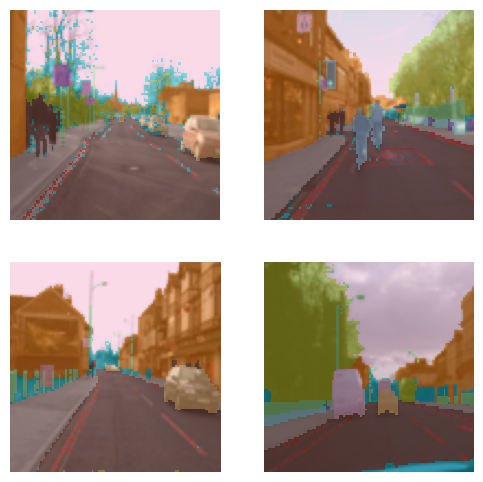

In [5]:
# Загружаем готовый размеченный датасет CamVid_Tiny
path = untar_data(URLs.CAMVID_TINY)  # Автоматически скачиваем и разархивируем небольшой датасет CamVid

# Загружаем список классов (объектов для сегментации)
codes = np.loadtxt(path/'codes.txt', dtype=str)  # Считываем классы объектов из текстового файла
print(f"Перечень классов для обучения: {codes}")

# Проверяем файлы масок
#print("Файлы в  labels:", get_image_files(path/'labels'))  # Выводим список файлов с разметкой (масками)

# Создаем DataBlock - абстракцию для подготовки данных
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),  # Определяем, что входные данные - изображения, а выходные - маски
    get_items=get_image_files,  # Функция, которая получает список всех изображений в указанной папке
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # Разбиваем данные: 80% - обучение, 20% - валидация
    get_y=lambda o: path/'labels'/(o.stem + '_P.png'),  # Определяем путь к маске по имени изображения
    item_tfms=[Resize(256)],  # Трансформация изображения
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]  # Нормализация пикселей изображений по статистике ImageNet
)

# Создаем DataLoaders для загрузки данных в модель
dls = dblock.dataloaders(path/'images', bs=4)  # Создаем загрузчики данных с размером батча 4

dls.show_batch(max_n=4, figsize=(6,6))  # Отображаем примеры изображений и их масок

In [7]:
# Создание модели U-Net для сегментации изображений
learn_34 = unet_learner(dls, resnet34, metrics=DiceMulti)  # Используем U-Net с энкодером ResNet34 и метрикой Dice Score

# Обучение модели
learn_34.fine_tune(5)  # Тренируем модель в 5 эпох, сначала с замороженными, затем с разомороженными весами

epoch,train_loss,valid_loss,dice_multi,time
0,2.222739,1.575049,0.073159,00:02


epoch,train_loss,valid_loss,dice_multi,time
0,1.324789,1.152733,0.115945,00:02
1,1.256177,1.024580,0.128057,00:02
2,1.159282,0.933994,0.167690,00:02
3,1.032730,0.778252,0.192881,00:02
4,0.928615,0.738132,0.209421,00:02


Результаты обученной модели (стартовая)


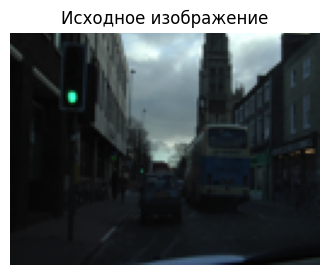

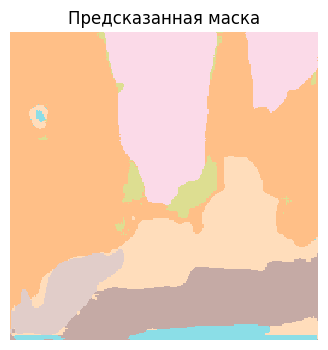

In [11]:
# Тестируем стартовую модель модель на новом изображении
img = PILImage.create(get_image_files(path/'images')[0])  # Загружаем одно из тестовых изображений

print("Результаты обученной модели (стартовая)")
test_model(learn_34, img)

In [13]:
dblock_512 = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda o: path/'labels'/(o.stem + '_P.png'),
    item_tfms=[Resize(512)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)

# Создаем DataLoaders для загрузки данных в модель
dls_512 = dblock_512.dataloaders(path/'images', bs=4)  # Создаем загрузчики данных с размером батча 4

# Создание модели U-Net для сегментации изображений
learn_34_512 = unet_learner(dls_512, resnet34, metrics=DiceMulti)  # Используем U-Net с энкодером ResNet34 и метрикой Dice Score

# Обучение модели
learn_34_512.fine_tune(5)  # Тренируем модель в 5 эпох, сначала с замороженными, затем с разомороженными весами

epoch,train_loss,valid_loss,dice_multi,time
0,2.471077,1.805452,0.075174,00:06


epoch,train_loss,valid_loss,dice_multi,time
0,1.489637,1.179061,0.097651,00:07
1,1.373623,1.163476,0.098171,00:06
2,1.192627,0.890319,0.169568,00:06
3,1.052770,0.776399,0.202186,00:06
4,0.948933,0.776399,0.204636,00:06


Результаты обученной модели (разрешение 512х512)


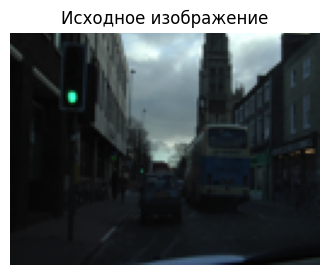

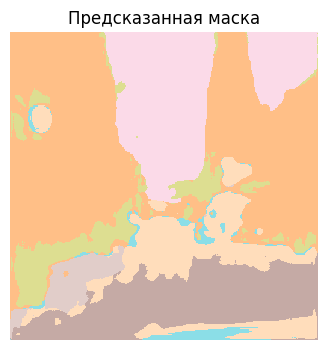

In [15]:
print("Результаты обученной модели (разрешение 512х512)")
test_model(learn_34_512, img)

In [17]:
learn_101 = unet_learner(dls, resnet101, metrics=DiceMulti)
learn_101.fine_tune(5)

epoch,train_loss,valid_loss,dice_multi,time
0,2.605488,2.162333,0.065222,00:12


epoch,train_loss,valid_loss,dice_multi,time
0,1.456920,1.378035,0.094385,00:45
1,2.022519,1.943839,0.062936,00:47
2,1.918636,1.605192,0.094070,00:38
3,1.677738,1.110295,0.100756,00:45
4,1.464709,1.054344,0.112147,00:46


Результаты обученной модели (resnet101)


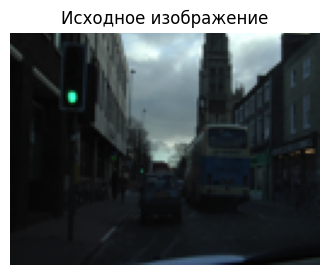

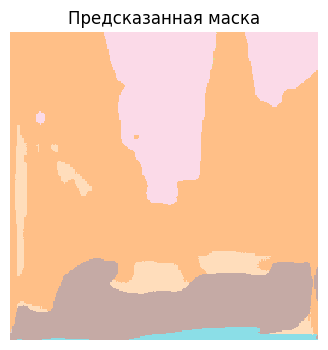

In [19]:
print("Результаты обученной модели (resnet101)")
test_model(learn_101, img)

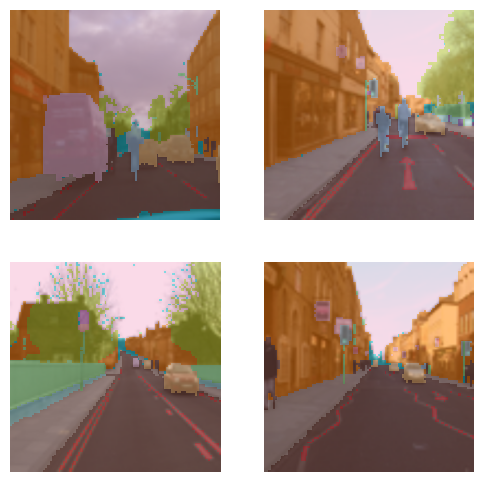

In [21]:
dblock_tfms = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda o: path/'labels'/(o.stem + '_P.png'),
    item_tfms=[Resize(256)],
    batch_tfms=[Normalize.from_stats(*imagenet_stats),Brightness(max_lighting=0.3), Contrast(max_lighting=0.3)]
)

dls_tfms = dblock_tfms.dataloaders(path/'images', bs=4)
dls_tfms.show_batch(max_n=4, figsize=(6,6))

In [23]:
learn_34_aug = unet_learner(dls_tfms, resnet34, metrics=DiceMulti)
learn_34_aug.fine_tune(5)

epoch,train_loss,valid_loss,dice_multi,time
0,2.449026,2.011288,0.077238,00:03


epoch,train_loss,valid_loss,dice_multi,time
0,1.513698,1.307069,0.086915,00:14
1,1.291143,1.066869,0.117485,00:14
2,1.115739,0.867268,0.193146,00:14
3,0.975243,0.673123,0.211817,00:14
4,0.871749,0.671167,0.220172,00:16


Результаты обученной модели (с добавление яркости и контрастности)


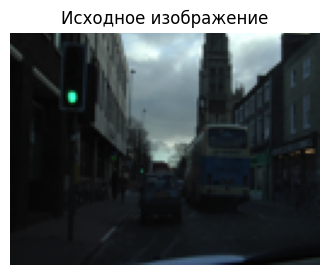

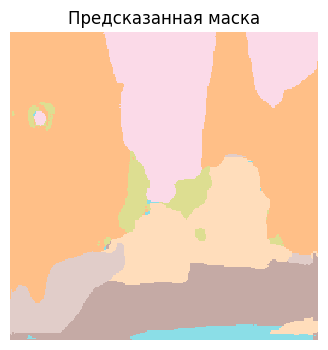

In [25]:
print("Результаты обученной модели (с добавление яркости и контрастности)")
test_model(learn_34_aug, img)

In [27]:
dls_optim = dblock.dataloaders(path/'images', bs=8)
learn_34_optim = unet_learner(dls_optim, resnet34, metrics=DiceMulti)
learn_34_optim.fine_tune(10)

epoch,train_loss,valid_loss,dice_multi,time
0,3.913951,2.518588,0.047487,00:14


epoch,train_loss,valid_loss,dice_multi,time
0,1.935666,1.604306,0.087187,00:21
1,1.668519,1.175850,0.095850,00:19
2,1.479604,1.048883,0.134287,00:19
3,1.364074,0.925039,0.145512,00:18
4,1.225073,0.805335,0.197214,00:18
5,1.096617,0.654002,0.205543,00:19
6,0.995241,0.647704,0.212969,00:18
7,0.908055,0.605610,0.225922,00:18
8,0.839914,0.598755,0.233072,00:23
9,0.786899,0.595226,0.233419,00:18


Результаты обученной модели (с увеличенным barch_size = 8 и epochs = 10)


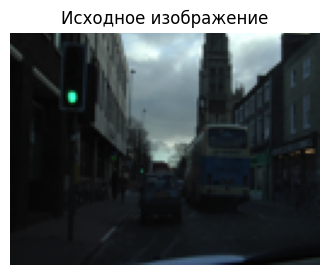

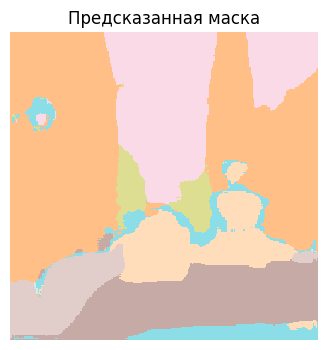

In [29]:
print("Результаты обученной модели (с увеличенным barch_size = 8 и epochs = 10)")
test_model(learn_34_optim, img)

In [31]:
learn_34_iou = unet_learner(dls, resnet34, metrics=[DiceMulti, JaccardCoeff])
learn_34_iou.fine_tune(5)

epoch,train_loss,valid_loss,dice_multi,jaccard_coeff,time
0,2.519702,1.794014,0.062331,-1.128404,00:40


epoch,train_loss,valid_loss,dice_multi,jaccard_coeff,time
0,1.393432,1.166985,0.103826,-1.133639,00:44
1,1.254537,1.042669,0.134471,-1.142264,00:39
2,1.110991,0.840189,0.196416,-1.122134,00:41
3,0.971056,0.730385,0.213682,-1.120951,00:39
4,0.865738,0.677542,0.222953,-1.119306,00:39


Результаты обученной модели (с увеличенным barch_size = 8 и epochs = 10)


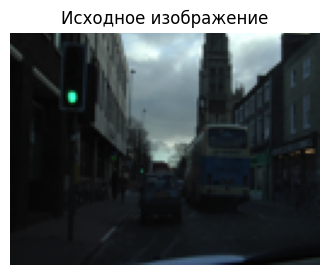

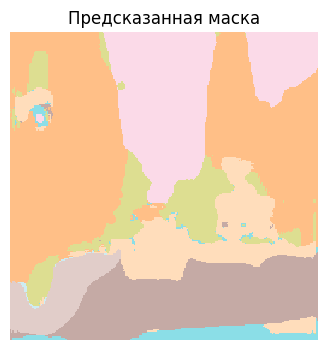

In [33]:
print("Результаты обученной модели (с увеличенным barch_size = 8 и epochs = 10)")
test_model(learn_34_iou, img)